## WORD2VEC

In [1]:
import collections
import math
import os
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  
print ("Packages loaded")

Packages loaded


## DOWNLOAD CORPUS

In [3]:
folder_dir  = "data"
file_name   = "text8.zip"
file_path   = os.path.join(folder_dir, file_name)
url         = 'http://mattmahoney.net/dc/'
if not os.path.exists(file_path):
    print ("No file found. Start downloading")
    downfilename, _ = urllib.request.urlretrieve(
        url + file_name, file_path)
    print ("'%s' downloaded" % (downfilename))
else:
    print ("File already exists")

No file found. Start downloading
'data/text8.zip' downloaded


## CHECK 

In [4]:
statinfo = os.stat(file_path)
expected_bytes = 31344016
if statinfo.st_size == expected_bytes:
    print ("I guess we have correct file at '%s'" % (file_path))
else:
    print ("Something's wrong with the file at '%s'" % (file_path))

I guess we have correct file at 'data/text8.zip'


## UNZIP

In [5]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = f.read(f.namelist()[0]).split()
    return data
words = read_data(file_path) 
print ("Type of 'words' is %s / Length is %d " 
       % (type(words), len(words)))
print ("'words' look like \n %s" %(words[0:100]))

Type of 'words' is <type 'list'> / Length is 17005207 
'words' look like 
 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


## MAKE DICTIONARY

In [6]:
vocabulary_size = 50000 
count = [['UNK', -1]] 
count.extend(collections.Counter(words)
             .most_common(vocabulary_size - 1)) # -1 is for UNK 
print ("Type of 'count' is %s / Length is %d " % (type(count), len(count)))
print ("'count' looks like \n %s" % (count[0:10]))

Type of 'count' is <type 'list'> / Length is 50000 
'count' looks like 
 [['UNK', -1], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]


### DICTIONARY

In [7]:
dictionary = dict() 
for word, _ in count:
    dictionary[word] = len(dictionary)
print ("Type of 'dictionary' is %s / Length is %d " 
       % (type(dictionary), len(dictionary)))

Type of 'dictionary' is <type 'dict'> / Length is 50000 


### REVERSE DICTIONARY

In [8]:
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
print ("Type of 'reverse_dictionary' is %s / Length is %d " 
       % (type(reverse_dictionary), len(reverse_dictionary)))

Type of 'reverse_dictionary' is <type 'dict'> / Length is 50000 


## MAKE DATA

In [9]:
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
count[0][1] = unk_count

### 'DICTIONARY' CONVERTS WORD TO INDEX
### 'REVERSE_DICTIONARY' CONVERTS INDEX TO WORD

In [11]:
print ("Most common words (+UNK) are: %s" % (count[:5]))

Most common words (+UNK) are: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


### DATA (INDICES)

In [12]:
print ("Sample data: %s" % (data[:10]))

Sample data: [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


### CONVERT TO CHAR

In [13]:
print ("Sample data corresponds to\n__________________")
for i in range(10):
    print ("%d->%s" % (data[i], reverse_dictionary[data[i]]))

Sample data corresponds to
__________________
5239->anarchism
3084->originated
12->as
6->a
195->term
2->of
3137->abuse
46->first
59->used
156->against


## BATCH-GENERATING WITH SKIP-GRAM MODEL

In [14]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # '//' makes the result an integer, e.g., 7//3 = 2
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

### EXAMPLES FOR GENERATING BATCH AND LABELS

In [15]:
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print ("Type of 'batch' is %s / Length is %d " 
       % (type(batch), len(batch))) 
print ("Type of 'labels' is %s / Length is %d " 
       % (type(labels), len(labels)))

Type of 'batch' is <type 'numpy.ndarray'> / Length is 8 
Type of 'labels' is <type 'numpy.ndarray'> / Length is 8 


In [16]:
print ("'batch' looks like \n %s" % (batch))

'batch' looks like 
 [3084 3084   12   12    6    6  195  195]


In [17]:
print ("'labels' looks like \n %s" % (labels))

'labels' looks like 
 [[  12]
 [5239]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   2]
 [   6]]


In [18]:
for i in range(8):
    print ("%d -> %d" 
           % (batch[i], labels[i, 0])),
    print ("\t%s -> %s" 
           % (reverse_dictionary[batch[i]]
              , reverse_dictionary[labels[i, 0]]))

3084 -> 12 	originated -> as
3084 -> 5239 	originated -> anarchism
12 -> 3084 	as -> originated
12 -> 6 	as -> a
6 -> 12 	a -> as
6 -> 195 	a -> term
195 -> 2 	term -> of
195 -> 6 	term -> a


## BUILD A SKIP-GRAM MODEL

In [19]:
batch_size     = 128
embedding_size = 128       # Dimension of the embedding vector.
skip_window    = 1         # How many words to consider left and right.
num_skips      = 2         # How many times to reuse an input 
print ("Parameters ready")

Parameters ready


In [20]:
# Random validation set to sample nearest neighbors.
valid_size     = 32        # Random set of words to evaluate similarity 
valid_window   = 200       # Only pick validation samples in the top 200
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

print (valid_examples)

[ 90  91 110   0 134  92 138  75 125 180  11  66  36 179 107   8 144 174
  82  79 145  83  57 190  34  50 127  35  42 194 153  15]


## DEFINE NETWORK

In [21]:
# Construct the word2vec model 
train_inputs   = tf.placeholder(tf.int32, shape=[batch_size])   
train_labels   = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset  = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs. (vocabulary_size = 50,000)
with tf.variable_scope("EMBEDDING"):
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size]
                              , -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
# Construct the variables for the NCE loss
with tf.variable_scope("NCE_WEIGHT"):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
print ("Network ready")

Network ready


## DEFINE FUNCTION

In [23]:
with tf.device('/cpu:0'):
    # Loss function 
    num_sampled = 64        # Number of negative examples to sample. 
    """
    loss = tf.reduce_mean(
        tf.nn.nce_loss(nce_weights, nce_biases, embed
                       , train_labels, num_sampled, vocabulary_size))
    """
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))
    
    # Optimizer
    optm = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    # Similarity measure (important)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings
                    , valid_dataset)
    siml = tf.matmul(valid_embeddings, normalized_embeddings
                    , transpose_b=True)
    
print ("Functions Ready")


Functions Ready


## TRAIN

In [25]:
# Train! 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
average_loss = 0

num_steps = 100001
for iter in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
    _, loss_val = sess.run([optm, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if iter % 2000 == 0:
        average_loss /= 2000
        print ("Average loss at step %d is %.3f" % (iter, average_loss)) 
    
    if iter % 10000 == 0:
        siml_val = sess.run(siml)
        for i in xrange(valid_size): # Among valid set 
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 6 # number of nearest neighbors
            nearest = (-siml_val[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to '%s':" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]] 
                log_str = "%s '%s'," % (log_str, close_word)
            print(log_str) 
            
# Final embeding 
final_embeddings = sess.run(normalized_embeddings)

Average loss at step 0 is 0.136
Nearest to 'use': 'advertiser', 'anode', 'busey', 'wessel', 'eugen', 'lanes',
Nearest to 'th': 'semivowel', 'thermotropic', 'vance', 'ger', 'rulership', 'modem',
Nearest to 'well': 'excessive', 'refrained', 'sl', 'athletics', 'wynn', 'affirming',
Nearest to 'UNK': 'besieged', 'immigrated', 'beverage', 'civil', 'tremblay', 'gomes',
Nearest to 'including': 'savages', 'anemometers', 'eponym', 'michele', 'tms', 'bradman',
Nearest to 'system': 'gollancz', 'carinthia', 'dhimmi', 'anticonvulsants', 'waste', 'repr',
Nearest to 'each': 'confirmed', 'nostalgic', 'suffragan', 'conform', 'precursors', 'latte',
Nearest to 'd': 'gera', 'mortimer', 'thinning', 'ojibwe', 'avestan', 'badger',
Nearest to 'because': 'wrecking', 'cleanup', 'iq', 'brunel', 'uvs', 'aki',
Nearest to 'south': 'images', 'went', 'twitch', 'naturalization', 'cumulative', 'philosophicus',
Nearest to 'is': 'sculptures', 'denver', 'amphibian', 'keswick', 'nassau', 'tritium',
Nearest to 'these': 'aeol

## VISUALIZE

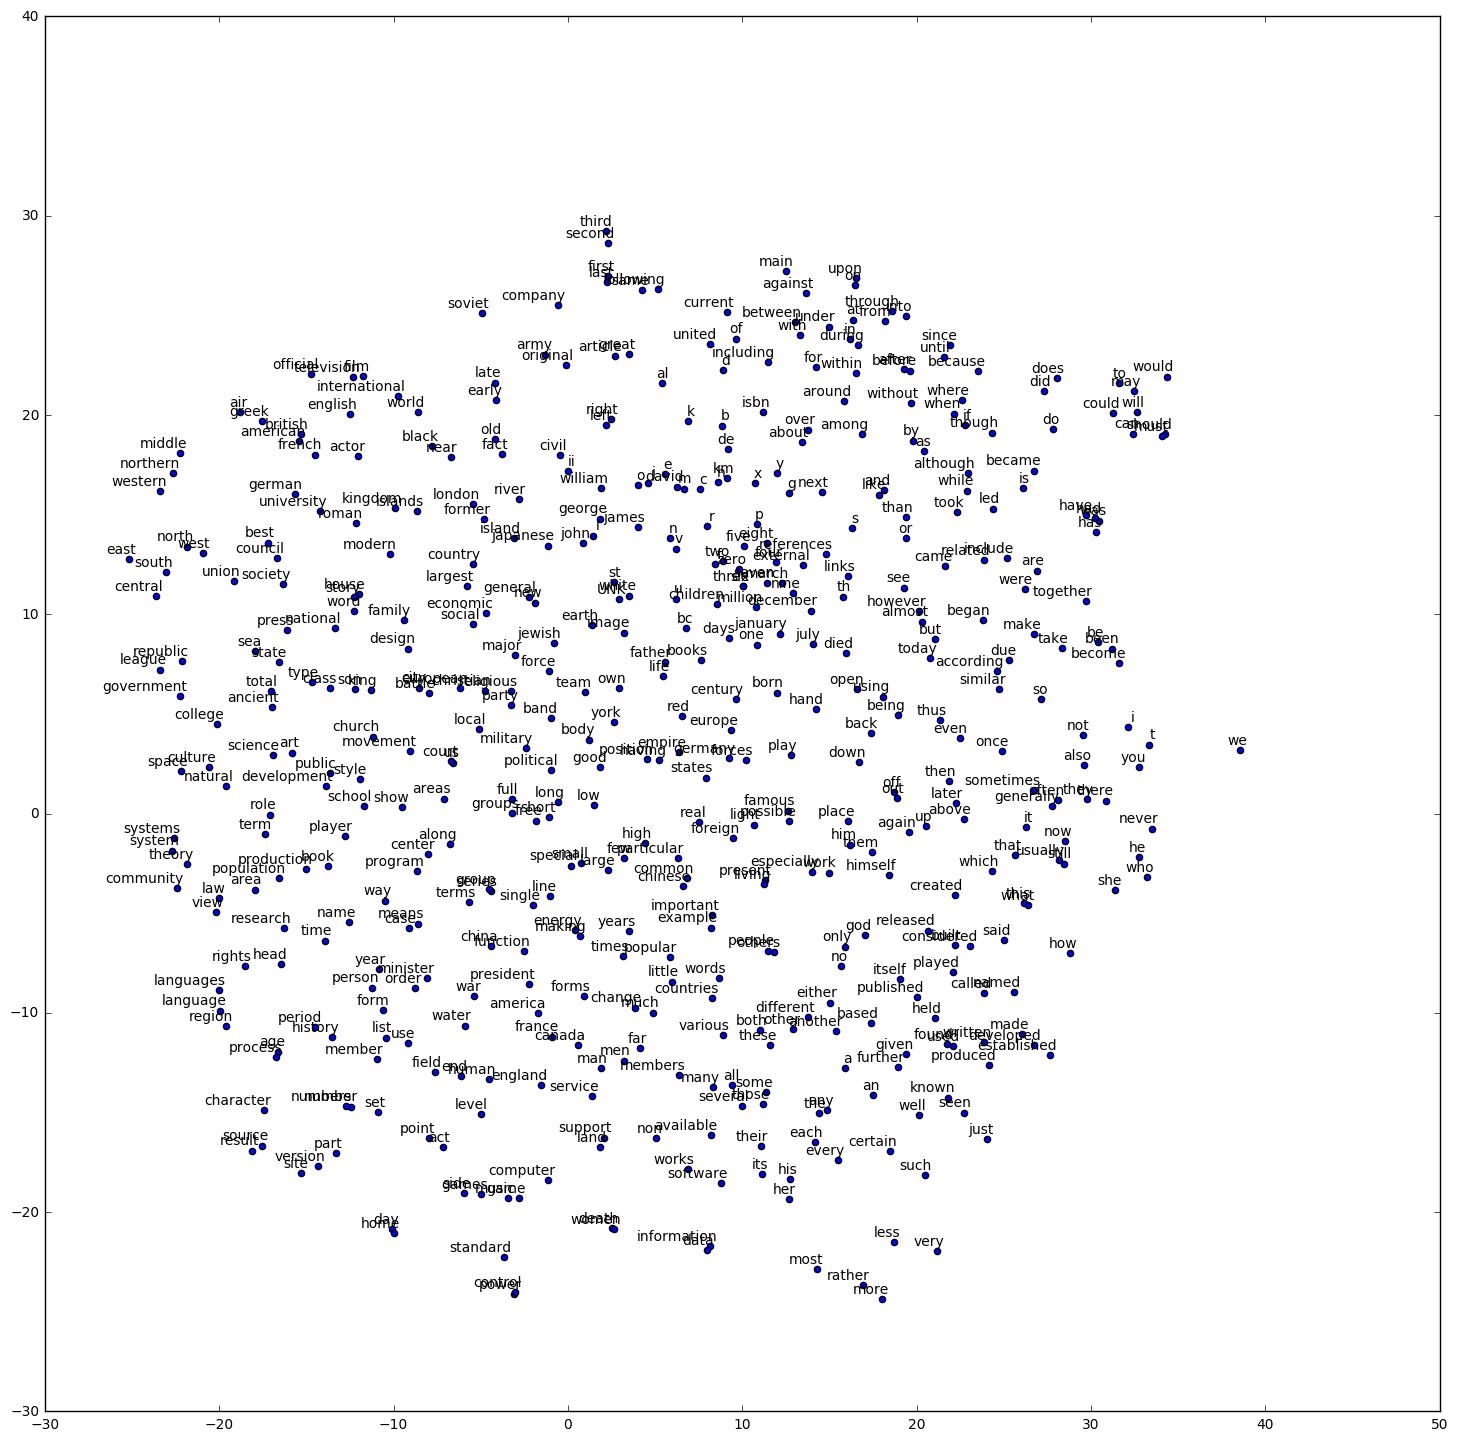

In [26]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
# Plot
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)